## Question 1
Spam filtering is an example of document classification task which involves classifying an email / SMS as spam or non-spam (a.k.a. ham).

1. Import the dataset from https://www.kaggle.com/uciml/sms-spam-collection-dataset. (1 point).
2. Split the data into training and testing. (1 point). Use 10-fold cross validation.(1 point)
3. Extract features using TF-IDF and display the features. ( 2 points)
4. Model and train the classifier using GaussianNB, BernoulliNB and MultinomialNB.( 3 points)
5. Evaluate classifiers on Test Data. ( 2 points)
6. Plot the decision boundary, visualize training and test results of all the models (3 points)

In [1]:
# importing required packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk  
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import re
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Mayank/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Mayank/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Method to plot the confusion matrix
model_list = []
accuracy_score_list = []
def plot_confusion_matrices(confusion_matrices):
    fig, axs = plt.subplots(2,5, figsize=(15,5)) 
    m = 0
    for i, ax_r in enumerate(axs):
        for j, ax in enumerate(ax_r):
            sns.heatmap(confusion_matrices[m], annot=True, cbar=False, cmap='Blues', fmt='g', ax = ax)
            ax.set_xlabel('Predicted label')
            ax.set_ylabel('True label')
            ax.set_title('{} {}'.format('fold', (m + 1)), fontsize=12, fontweight='bold')
            m += 1

    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.tight_layout()
    plt.show()

In [3]:
# Method to create PCA and visualize scatter plot
def pca_scatter_plot(X, model):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(
                        data = principalComponents,
                        columns = ['principal component 1', 'principal component 2']
                        )
    df = pd.concat([principalDf, dataset.class_label], axis=1)
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1,1,1)
    class_label_map = {'spam': 1, 'ham': 0}

    for label in ['Spam','Ham']:

        plt.scatter(df['principal component 1'], 
                    df['principal component 2'],
                    c=np.vectorize(class_label_map.get)(model.predict(X)),
                    marker='o',
                    alpha=0.1,
                    label=label
               )

    ax.legend()
    ax.grid(True)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.show()

<span style="color:blue"><b>Step 1: Downloaded the dataset from the provided link and put it on a public repository so that it can be read directly.</b></span>

In [4]:
url = 'https://raw.githubusercontent.com/brajbhushan-tripathi/ML_Assignment/master/Question1/spam.csv'
dataset = pd.read_csv(url, delimiter=',',encoding='latin-1')
dataset.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
dataset.columns = ['class_label','email_text']
dataset.head()

,class_label,email_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Preprocessing the data

In [5]:
# Cleaning up the data
X = dataset.email_text.values  
y = dataset.class_label

processed_email_texts = []

for text in range(0, len(X)):  
    # Remove all the special characters
    processed_email_text = re.sub(r'\W', ' ', str(X[text]))
 
    # Substituting multiple spaces with single space
    processed_email_text= re.sub(r'\s+', ' ', processed_email_text, flags=re.I)
    
    # Remove stop words from email text
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    processed_email_text = pattern.sub('', processed_email_text)
  
    # Converting to Lowercase
    processed_email_text = processed_email_text.lower()

    processed_email_texts.append(processed_email_text)

<span style="color:blue"><b>Step 3: Extracting features using TF-IDF and displaying the features.</b></span>

In [6]:
# TF-IDF vectorization
tfidfconverter = TfidfVectorizer(
                    max_features=2000,
                    min_df=10,
                    max_df=0.9,
                    ngram_range=(1,3),
                    tokenizer=nltk.tokenize.word_tokenize
                    )
X = tfidfconverter.fit_transform(processed_email_texts).toarray()

In [7]:
# Display sample feature list with TF-IDF score
feature_list = pd.concat([pd.Series(tfidfconverter.get_feature_names()),
                          pd.Series(tfidfconverter.idf_)], axis=1)
                          
feature_list.sample(5)

,0,1
491,happiness,7.060739
1249,well,4.855004
577,i take,7.060739
767,n,4.789407
332,draw shows,6.853100


<div style="color:blue"><b>Step 2, 4, 5:<ul><li>Splitting the data in train and test.</li><li>Using 10-fold cross validation.</li><li>   Modelling and training the classifier</li><li>Evalution of the model on test data.<ul></b></div>

<div style="color:blue"><b>Step 6: Due to the nature of the data we aren't able to plot decision boundaries. So, as suggested by faculty, we are displaying the scatter plot by creating 2 principal components.</b></div>

#### GaussianNB

0.8641396884230034


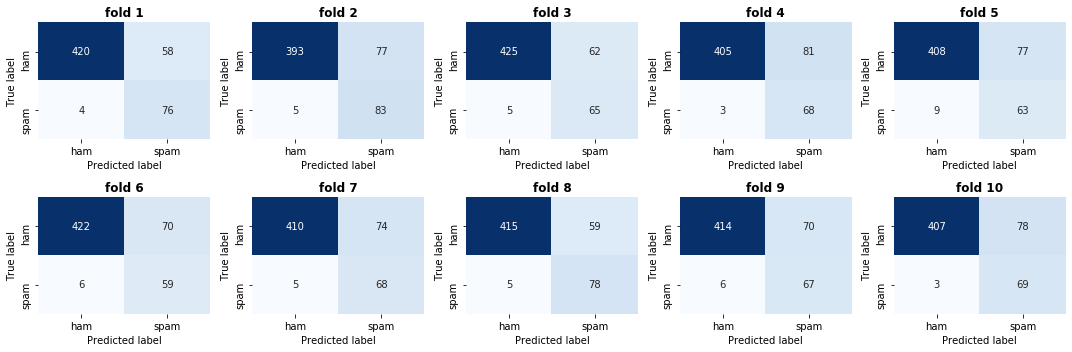

In [8]:
# Creating Gaussion Naive Bayes Model
scores = []
m1 = GaussianNB()
model_list.append('Gaussian Naive Bayes')
conf_matrices = []

# Using 10-Fold cross validation
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]
    m1.fit(X_train, y_train)
    y_pred = m1.predict(X_test)
    scores.append(m1.score(X_test, y_test))
    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['ham', 'spam'], index=['ham','spam'])
    conf_matrices.append(conf_matrix)

# Print mean accuracy score
mean_score = np.mean(scores)
print(mean_score)

accuracy_score_list.append(mean_score)
# Plot confusion matrix for evaluation
plot_confusion_matrices(conf_matrices)

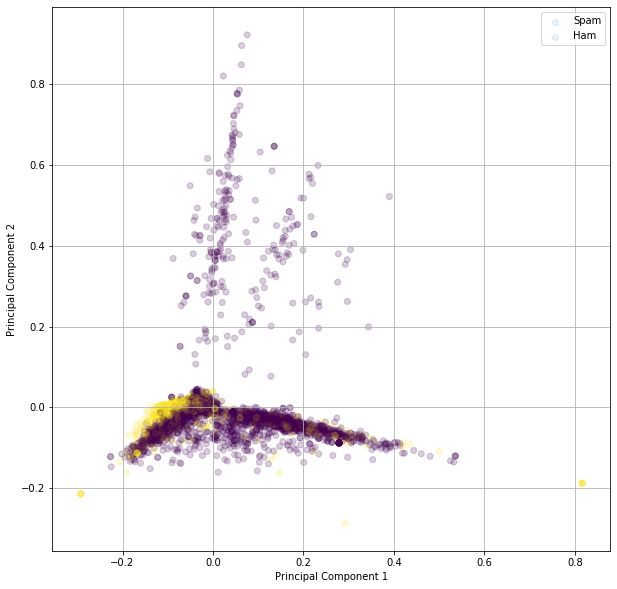

In [9]:
# Scatter Plot
pca_scatter_plot(X, m1)

#### MultinomialNB

0.9847445030018728


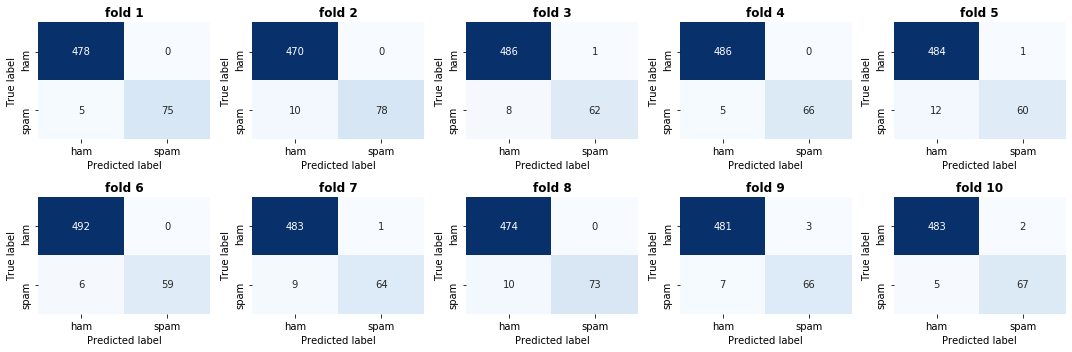

In [10]:
# Creating Multinomial Naive Bayes Model
scores = []
m1 = MultinomialNB()
model_list.append('Multinomial Naive Bayes')
conf_matrices = []

# Using 10-Fold cross validation
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]
    m1.fit(X_train, y_train)
    y_pred = m1.predict(X_test)
    scores.append(m1.score(X_test, y_test))
    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['ham', 'spam'], index=['ham','spam'])
    conf_matrices.append(conf_matrix)

# Print mean accuracy score
mean_score = np.mean(scores)
print(mean_score)

accuracy_score_list.append(mean_score)
# Plot confusion matrix for evaluation
plot_confusion_matrices(conf_matrices)

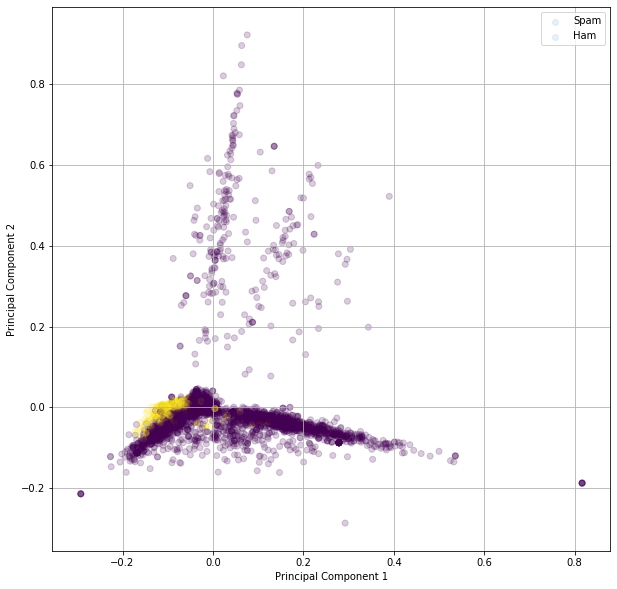

In [11]:
# Scatter Plot
pca_scatter_plot(X, m1)

#### BernoulliNB

0.985103891173272


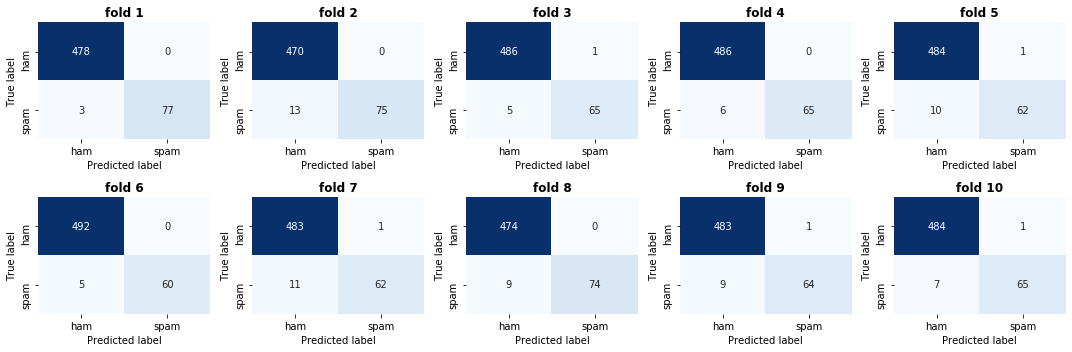

In [12]:
# Creating Bernoulli Naive Bayes Model
scores = []
m1 = BernoulliNB()
model_list.append('Bernoulli Naive Bayes')
conf_matrices = []

# Using 10-Fold cross validation
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]
    m1.fit(X_train, y_train)
    y_pred = m1.predict(X_test)
    scores.append(m1.score(X_test, y_test))
    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['ham', 'spam'], index=['ham','spam'])
    conf_matrices.append(conf_matrix)

# Print mean accuracy score
mean_score = np.mean(scores)
print(mean_score)

accuracy_score_list.append(mean_score)
# Plot confusion matrix for evaluation
plot_confusion_matrices(conf_matrices)

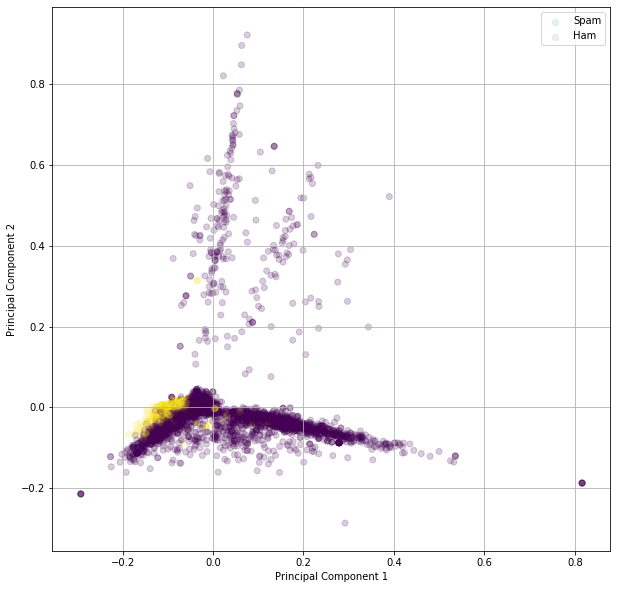

In [13]:
# Scatter Plot
pca_scatter_plot(X, m1)

#### Performance comparison 

In [14]:
results = pd.DataFrame(accuracy_score_list, index=list(model_list), columns=['test_accuracy'])
results

,test_accuracy
Gaussian Naive Bayes,0.864140
Multinomial Naive Bayes,0.984745
Bernoulli Naive Bayes,0.985104


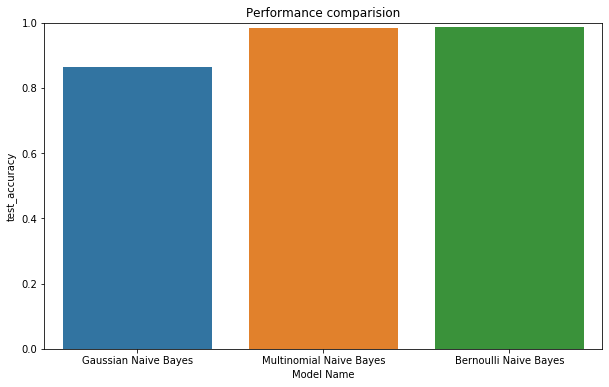

In [15]:
# Display bar chart to compare the performance
plt.figure(figsize=(10, 6))
sns.barplot(y ='test_accuracy', x=results.index, data=results)
plt.ylim(0., 1.0)
plt.title('Performance comparision')
plt.xlabel('Model Name')
plt.show()